In [3]:
import sys
!{sys.executable} -m pip install Rpy2 pandas yfinance sklearn matplotlib statsmodels yahoofinancials


  Using cached yahoofinancials-1.6-py3-none-any.whl
  Using cached beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Using cached soupsieve-2.2.1-py3-none-any.whl (33 kB)


In [3]:
import pandas as pd
import yfinance as yf
import numpy as np
import os
os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'
import rpy2.robjects as R
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from yahoofinancials import YahooFinancials
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm

Stock = yf.download('GOLD', 
                      start='2013-01-01', 
                      end='2019-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 

#all_data = Stock[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data = pd.read_csv('/mnt/distvol/re_fixed_multivariate_timeseries.csv').set_index('datetime')
#all_data = all_data.filter(['GBP/mWh','temperature','coal Price','oil Price','uranium Price','natural gas Price'])

#all_data['return'] = all_data['Adj Close'].pct_change()

#all_data = all_data.filter(['return','Adj Close','Open','High','Low','Close','Volume']).dropna()
all_data[23:47]
#all_data['Adj Close'].plot()
# There are 1,510 and 251 observations in the training and test data respectively.

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
datetime,,,,,,
2013-01-02 00:00:00,34.96,40.11,95.67,112.47,43.25,3.233
2013-01-02 01:00:00,31.31,40.91,95.67,112.47,43.25,3.233
2013-01-02 02:00:00,28.91,39.45,95.67,112.47,43.25,3.233
2013-01-02 03:00:00,28.03,38.71,95.67,112.47,43.25,3.233
2013-01-02 04:00:00,25.81,38.70,95.67,112.47,43.25,3.233
2013-01-02 05:00:00,30.08,38.60,95.67,112.47,43.25,3.233
2013-01-02 06:00:00,55.01,38.52,95.67,112.47,43.25,3.233
2013-01-02 07:00:00,39.09,39.94,95.67,112.47,43.25,3.233
2013-01-02 08:00:00,44.08,40.78,95.67,112.47,43.25,3.233


In [4]:
from datetime import datetime
all_data.index = pd.to_datetime(all_data.index)
#all_data.resample('D')


,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
datetime,,,,,,
2013-01-01 01:00:00,37.76,48.48,95.59,111.11,43.50,3.351
2013-01-02 01:00:00,31.31,40.91,95.67,112.47,43.25,3.233
2013-01-03 01:00:00,30.54,50.44,95.27,112.14,43.00,3.198
2013-01-04 01:00:00,34.92,51.17,95.36,111.31,43.00,3.287
2013-01-05 01:00:00,35.09,46.59,95.36,111.31,43.00,3.287
...,...,...,...,...,...,...
2019-12-27 01:00:00,28.73,46.25,70.40,67.92,25.05,2.294
2019-12-28 01:00:00,24.97,43.76,70.68,68.16,25.00,2.158
2019-12-29 01:00:00,23.55,44.38,70.68,68.16,25.00,2.158


In [5]:
X = all_data.iloc[:,1:]
X = X.reset_index().iloc[:,1:]

Xminus1 = all_data.iloc[:,1:].shift(-23).dropna()
Xminus1 = Xminus1.reset_index().iloc[:,1:]

y = all_data.iloc[:,0]
y = y.reset_index().iloc[:,1:]
ylim = y[0:len(Xminus1)]
reg = LinearRegression().fit(Xminus1.dropna(), y[0:len(Xminus1)])

print(reg.score(X, y),reg.coef_,reg.intercept_)
print(reg.score(Xminus1, ylim),reg.coef_,reg.intercept_)

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

model = sm.OLS(ylim,Xminus1)
results = model.fit()
print(results.summary())





0.1472036200666461 [[ 0.03885018  0.5638297  -0.22641375  0.49913812  2.63528672]] [-6.25772283]
0.14799911801587873 [[ 0.03885018  0.5638297  -0.22641375  0.49913812  2.63528672]] [-6.25772283]
                                 OLS Regression Results                                
Dep. Variable:                GBP/mWh   R-squared (uncentered):                   0.890
Model:                            OLS   Adj. R-squared (uncentered):              0.890
Method:                 Least Squares   F-statistic:                          9.906e+04
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                        0.00
Time:                        18:52:19   Log-Likelihood:                     -2.5781e+05
No. Observations:               61326   AIC:                                  5.156e+05
Df Residuals:                   61321   BIC:                                  5.157e+05
Df Model:                           5                                                  
Covariance Ty

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
datetime,,,,,,
2013-01-01,38.667826,43.460870,95.590000,111.110000,43.500000,3.351000
2013-01-02,47.743333,44.395833,95.670000,112.470000,43.250000,3.233000
2013-01-03,45.578333,50.974583,95.270000,112.140000,43.000000,3.198000
2013-01-04,47.949583,49.754167,95.360000,111.310000,43.000000,3.287000
2013-01-05,45.370000,48.617917,95.360000,111.310000,43.000000,3.287000
...,...,...,...,...,...,...
2019-12-27,35.092083,45.504167,70.411667,67.930000,25.047917,2.288333
2019-12-28,31.996667,45.198333,70.680000,68.160000,25.000000,2.158000
2019-12-29,31.931667,43.014583,70.680000,68.160000,25.000000,2.158000


In [79]:
all_data.resample('D').mean()

R.r('''
           f <- function(values) {
                    #system("which openssl")

                    library(snpEnrichment)
                    library(arfima)
                    library(parallel)
                    library(forecast)                    
                    
                    dset <- mclapply(1:ncol(values),function(x)
                    {
                        column = values[,x]
                        
                        
                        #tryCatch(invisible(capture.output(suppressMessages(suppressWarnings(
                        #{
                          varvefd = arfima(column)
                          d = summary(varvefd)$coef[[1]][1]
                          return(d)
                        #}
                       #)
                       #))),
                        #error=function(e)
                          #{
                            #d = 1
                            #return(d)
                          #})
                    
                    })    
                    
                    unlist(dset)

            }
            ''')

r_f = R.globalenv['f']
d=R.conversion.rpy2py((r_f(R.conversion.py2rpy(all_data.resample('D').mean().dropna()))))


array([0.42705098, 0.4627948 , 0.49973274, 0.49973274, 0.49972444,
       0.49940688])

'[1] 0.4627948'


In [7]:
dataframe = {}
dataframe['Y'] = R.FloatVector((y.iloc[:,0]))
dataframe['X'] = R.FloatVector((X.iloc[:,0]))

MyRDataFrame = R.DataFrame(dataframe)

fit = R.r.lm(MyRDataFrame)
summary = R.r.summary(fit)

print(summary[3])

#varvefd(MyRDataFrame)

#d = R.r.varvefd())
#$coef[[1]][1]

[[ 4.96373325e+01  3.51920601e-01  1.41046965e+02  0.00000000e+00]
 [-7.65143249e-02  6.44717479e-03 -1.18678844e+01  1.88640047e-32]]


In [13]:

def ts_train_test_normalize(all_data,time_steps,for_periods, n_features):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set

    #n_features = 1
            
    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import QuantileTransformer
    #sc = MinMaxScaler()
    #sc = RobustScaler()
    #sc = Normalizer()
    sc = QuantileTransformer(output_distribution='normal')
    #sc = StandardScaler()
    
    #transform each range to scale
    
    sc.fit(all_data[(all_data.index<'2019')].iloc[:,0:n_features])
    
    #transform each range to scale
    
    #s_train_scaled = all_data[(all_data.index<'2017')].iloc[:,0:n_features].values
    ts_train_scaled = sc.transform(all_data[(all_data.index<='2017')].iloc[:,0:n_features])    
    #ts_valid_scaled = all_data[(all_data.index>='2017')&(all_data.index<'2019')].iloc[:,0:n_features].values
    ts_valid_scaled = sc.transform(all_data[(all_data.index>'2017')&(all_data.index<'2019')].iloc[:,0:n_features])
    #ts_test_scaled  = all_data[(all_data.index>='2019')].iloc[:,0:n_features].values
    ts_test_scaled  = sc.transform(all_data[(all_data.index>='2019')].iloc[:,0:n_features])
    
    #new_series = pd.DataFrame(all_data[:'2017'].iloc[:,0:n_features].values).append(pd.DataFrame(all_data['2017':'2018'].iloc[:,0:n_features].values),ignore_index=True).append(pd.DataFrame(all_data['2019':].iloc[:,0:n_features].values),ignore_index=True)
    new_series = pd.DataFrame(ts_train_scaled).append(pd.DataFrame(ts_valid_scaled)).append(pd.DataFrame(ts_test_scaled))
    
    series_reshaped = np.array([new_series[i:i + (n_steps+n_ahead)].copy() for i in range(len(all_data) - (n_steps+n_ahead))])        
    
    X_train = series_reshaped[:len(ts_train_scaled)-(n_steps+n_ahead)+2,:n_steps]
    X_valid = series_reshaped[len(ts_train_scaled)-(n_steps+n_ahead)+2:len(ts_train_scaled)-(n_steps+n_ahead)+2+len(ts_valid_scaled),:n_steps]
    X_test = series_reshaped[-len(ts_test_scaled)+2:,:n_steps]
    
    Y = np.empty(((len(all_data) - n_steps - n_ahead), n_steps, n_ahead))  
    
    for step_ahead in range(1, n_ahead + 1):     
       Y[..., step_ahead - 1] =   series_reshaped[..., step_ahead:step_ahead + n_steps, 0]

    Y_train = Y[:len(ts_train_scaled)-(n_steps+n_ahead)+2,:n_steps]
    Y_valid = Y[len(ts_train_scaled)-(n_steps+n_ahead)+2:len(ts_train_scaled)-(n_steps+n_ahead)+2+len(ts_valid_scaled),:n_steps]
    Y_test = Y[-len(ts_test_scaled)+2:,:n_steps]
    
    #print(ts_train_scaled)
    return X_train, Y_train, X_valid, Y_valid, X_test, sc

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

def return_actual(model):

    Y_pred = model6.predict(X_test)

    last_list=[]

    for i in range (0, len(Y_pred)):
      last_list.append((Y_pred[i][0][n_ahead-1]))

    actual = pd.DataFrame((sc.inverse_transform(X_test[:,0])))
    #actual = pd.DataFrame(((X_test[:,0])))
    actual.rename(columns = {0:'actual'}, inplace = True)
    actual['predictions'] = last_list
    #actual['predictions'] = invTransform(sc,actual["predictions"],"Adj Close",all_data.columns)
    actual['predictions'] = invTransform(sc,actual["predictions"],all_data.columns[0],all_data.columns)
    actual['difference'] = (actual['predictions'] - actual['actual']).abs()
    actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100
    
    return(actual)

# - scaler   = the scaler object (it needs an inverse_transform method)
# - data     = the data to be inverse transformed as a Series, ndarray, ... 
#              (a 1d object you can assign to a df column)
# - ftName   = the name of the column to which the data belongs
# - colNames = all column names of the data on which scaler was fit 
#              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


/bin/bash: pip: command not found


In [28]:
def get_weights(d, num_k):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
    """
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def get_weights_floored(d, num_k, floor=1e-3):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$ provided weight above a minimum value
    (floor) for the weights to prevent computation of weights for the entire
    time series.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
        floor (float): minimum value for the weights for computational efficiency.
    """
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        
        k += 1

    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def frac_diff(df, d, floor=1e-3):
    r"""Fractionally difference time series via CPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights
    weights = weights[::-1]
    
    # Blank fractionally differenced series to be filled
    df_fd = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Dot product of weights and original values
        # to get fractionally differenced values
        date_idx = df.index[idx]
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())
    
    # Return FD values and weights
    df_fd = pd.DataFrame(df_fd)
    
    return df_fd, weights

array([48.48      , 25.86370829, 18.02056502, ...,  9.54127487,
        8.99370067,  8.01711538])

0.46279479608914875

array([48.48      , 25.86370829, 18.02056502, ...,  9.54127487,
        8.99370067,  8.01711538])

In [169]:

from fracdiff import fdiff

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED

cores = int(len(os.sched_getaffinity(0)))

def getDifferenced(i):
    #v = d[[i]]
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i], d=d[[i]], floor=5e-5)
    
    a = np.array(all_data.iloc[:, i])
    
    return fdiff(a, n=d[i], axis=0)
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i]), d=v, floor=5e-5)

pool01 = concurrent.futures.ProcessPoolExecutor(cores)

futures01 = [pool01.submit(getDifferenced, args) for args in range(0,len(d))]

wait(futures01, timeout=None, return_when=ALL_COMPLETED)


DoneAndNotDoneFutures(done={<Future at 0x7f9b6fca1a60 state=finished returned ndarray>, <Future at 0x7f9b1b3a5310 state=finished returned ndarray>, <Future at 0x7f9b22146130 state=finished returned ndarray>, <Future at 0x7f9b21b9d1c0 state=finished returned ndarray>, <Future at 0x7f9b21e4f9a0 state=finished returned ndarray>, <Future at 0x7f9b206a37c0 state=finished returned ndarray>}, not_done=set())

In [170]:
all_data.describe()

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
count,61326.000000,61326.000000,61326.000000,61326.000000,61326.000000,61326.000000
mean,45.546040,53.470933,75.892880,71.080666,29.704158,3.114925
std,17.539379,10.973151,15.889191,23.741530,6.717527,0.724992
min,-2.840000,22.020000,39.930000,27.880000,17.750000,1.639000
25%,35.600000,45.532500,64.237500,52.362500,24.450000,2.660000
50%,43.120000,53.000000,77.750000,63.610000,28.300000,2.939000
75%,52.100000,61.080000,87.530000,93.975000,35.750000,3.587750
max,999.000000,99.480000,111.160000,118.900000,44.000000,6.149000


In [205]:

Differenced_Set = pd.DataFrame()
for f in range(0,len(futures01)):
    value = pd.DataFrame(futures01[f].result())
    Differenced_Set = pd.concat([Differenced_Set,value],axis=1)
    
Differenced_Set.columns = all_data.columns

In [206]:
Differenced_Set.describe()

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
count,61326.000000,61326.000000,61326.000000,61326.000000,61326.000000,61326.000000
mean,11.309762,11.542161,14.093477,13.199903,5.516248,0.579214
std,13.043842,3.383718,2.978409,4.436647,1.260957,0.136474
min,-435.166523,-7.268672,3.763712,3.545058,2.485034,0.100337
25%,5.520487,9.212220,11.931934,9.725758,4.539958,0.493641
50%,9.399483,11.171021,14.433161,11.820194,5.254839,0.546445
75%,15.304046,13.434150,16.254159,17.345939,6.638179,0.667298
max,960.031144,48.480000,95.590000,111.110000,43.500000,3.351000


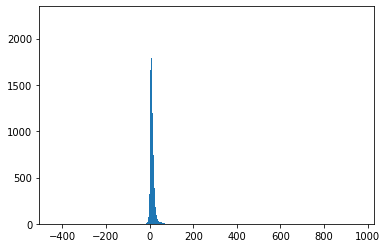

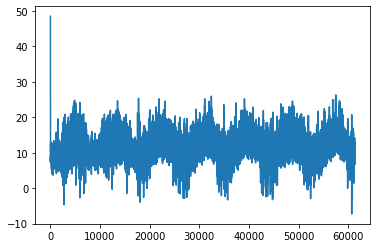

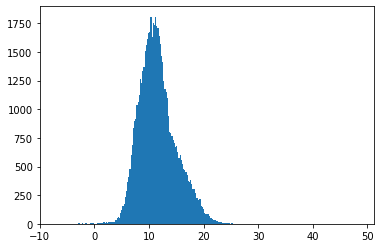

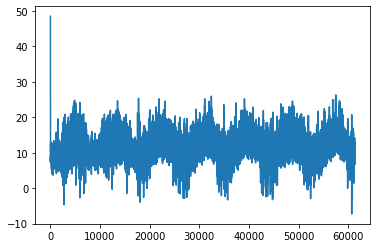

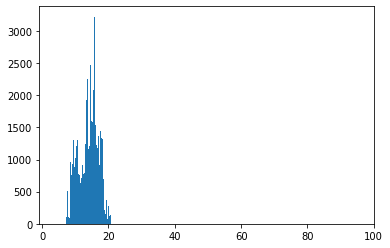

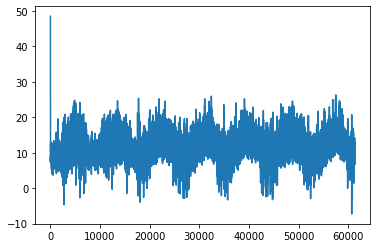

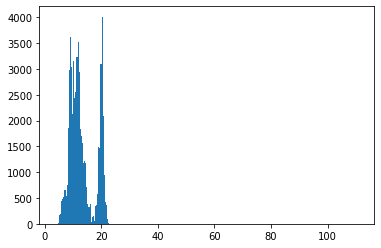

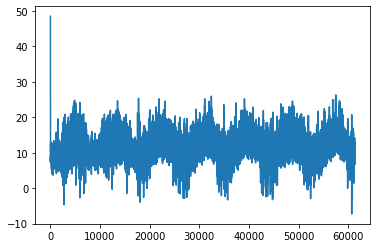

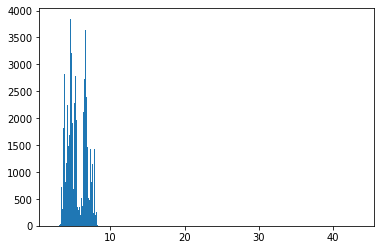

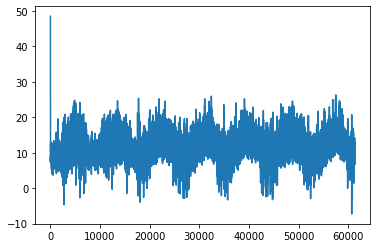

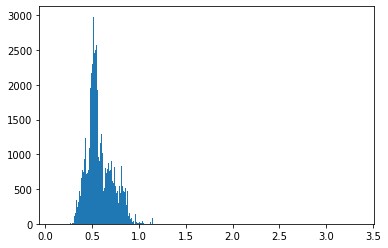

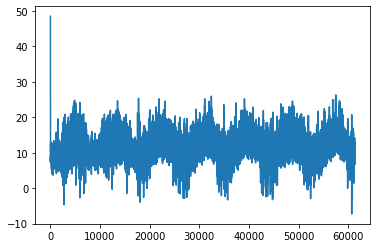

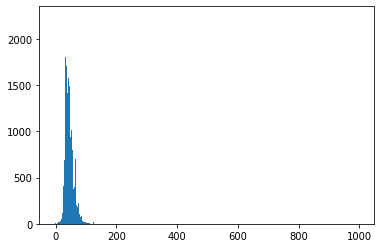

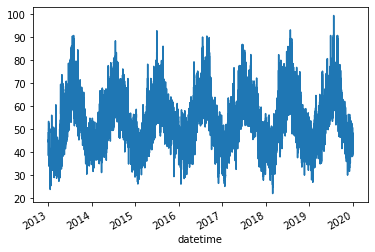

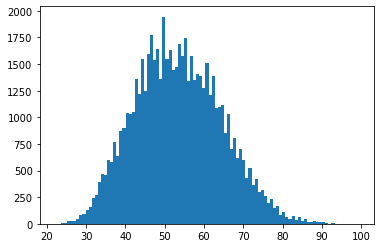

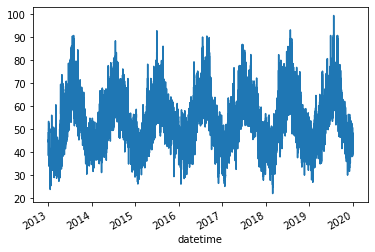

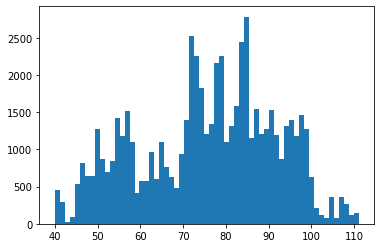

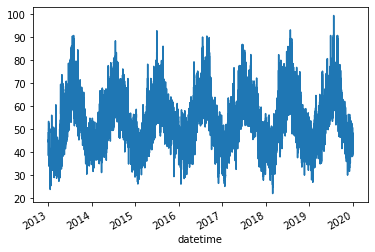

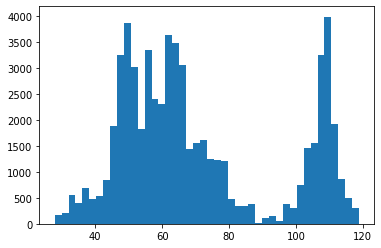

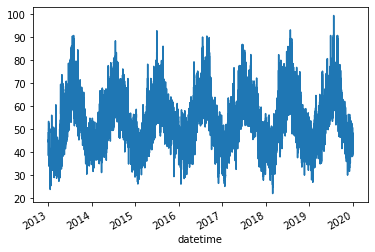

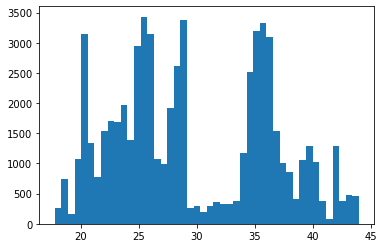

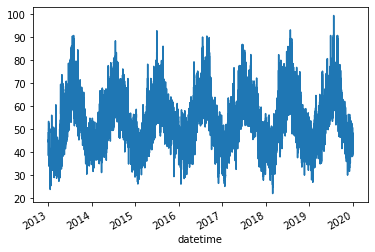

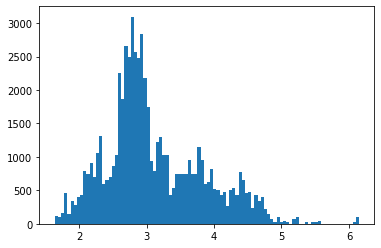

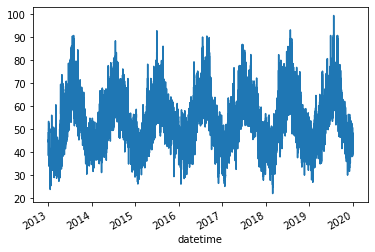

In [186]:

for f in range(0,len(futures01)):
    #print(f)
    #print(len(futures01[f].result()))
    plt.hist(Differenced_Set.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
    plt.show()
    Differenced_Set.iloc[:,1].plot()
    plt.show()
    
for f in range(0,len(all_data.columns)):
    #print(f)
    #print(len(futures01[f].result()))
    plt.hist(all_data.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
    plt.show()
    all_data.iloc[:,1].plot()
    plt.show()

0        48.480000
1        25.863708
2        18.020565
3        14.834289
4        12.626036
           ...    
61321    10.653504
61322    10.244942
61323     9.541275
61324     8.993701
61325     8.017115
Name: temperature, Length: 61326, dtype: float64

""


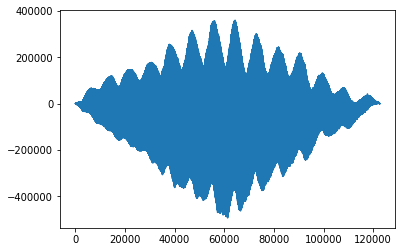

3023


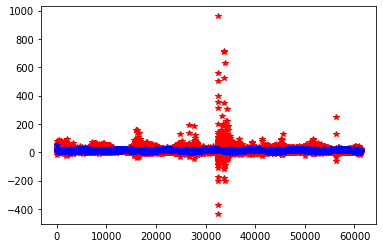

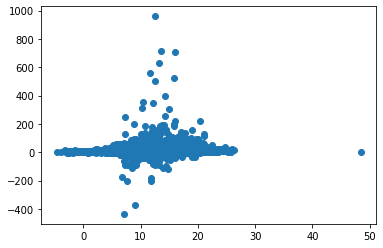

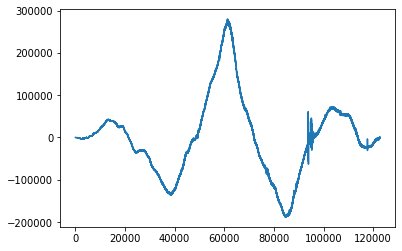

-6


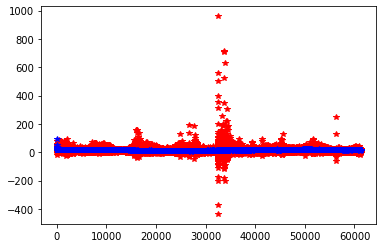

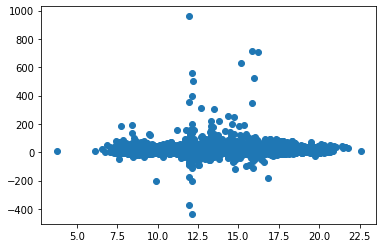

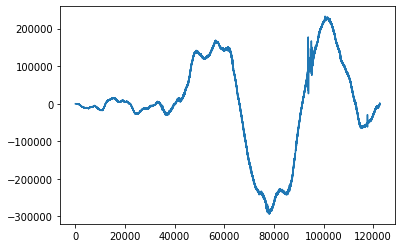

39293


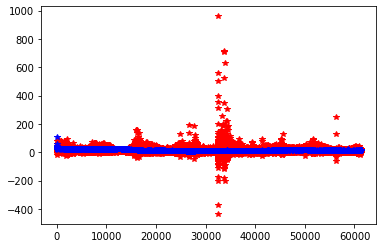

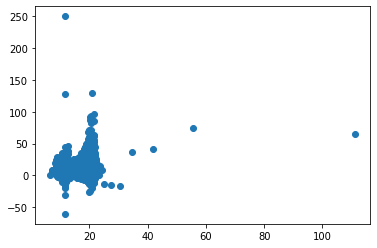

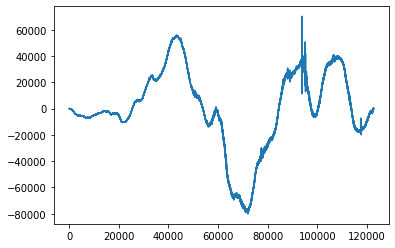

32482


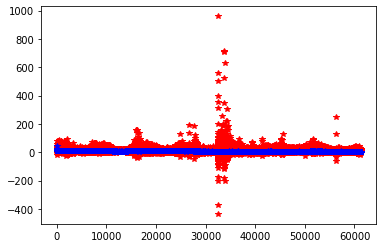

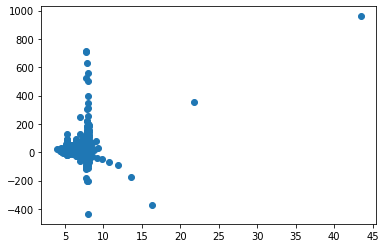

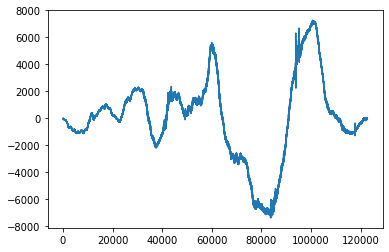

39293


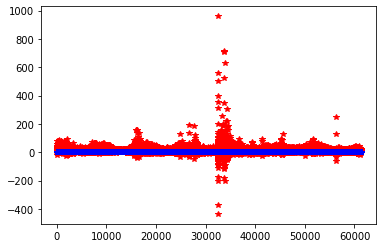

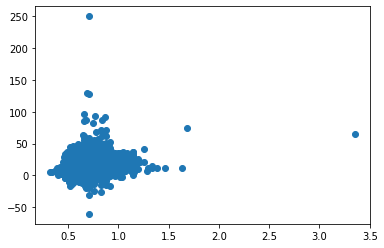

In [209]:
from scipy import signal
#corr = signal.correlate(sig_noise, np.ones(128), mode='same') / 128

for f in range(1,len(Differenced_Set.columns)):
    #print(f)
    #print(len(futures01[f].result()))
    data_1 = Differenced_Set.iloc[:,0]
    data_2 = Differenced_Set.iloc[:,f]

    corr = np.correlate(data_1 - np.mean(data_1), 
                        data_2 - np.mean(data_2),
                        mode='full')
    plt.plot(corr)
    plt.show()
    lag = corr.argmax() - (len(data_1) - 1)
    print(lag)
    plt.plot(data_1, 'r*')
    plt.plot(data_2, 'b*')
    plt.show()

    plt.scatter(data_2.shift(lag),data_1)
    plt.show()


In [14]:
n_steps = 21
n_ahead = 1
n_features = len(all_data)

X_train, Y_train, X_valid, Y_valid, X_test, sc = ts_train_test_normalize(all_data.resample('D').mean(),n_steps,n_ahead,n_features)
print(X_train.shape[0],X_train.shape[1],X_train.shape[2])
print(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2])
print(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2])
print(Y_valid.shape[0],Y_valid.shape[1],Y_valid.shape[2])
print(X_test.shape[0],X_test.shape[1],X_test.shape[2])

1442 21 6
1442 21 1
729 21 6
729 21 1
363 21 6


In [15]:
import tensorflow as tf
from tensorflow import keras
epochs_ = 100
batch_size_ = 150

np.random.seed(42)
tf.random.set_seed(42)

from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD

#simple RNN

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(all_data.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model6.compile(loss="mean_squared_error", optimizer="rmsprop",metrics=['mean_squared_error'])
history = model6.fit(X_train, Y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, Y_valid))


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Epoch 1/100
10/10 [==============================] - 2s 44ms/step - loss: 0.9230 - mean_squared_error: 0.9230 - val_loss: 0.3010 - val_mean_squared_error: 0.3010
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.3104 - mean_squared_error: 0.3104 - val_loss: 0.2076 - val_mean_squared_error: 0.2076
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.1799 - val_mean_squared_error: 0.1799
Epoch 4/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2201 - mean_squared_error: 0.2201 - val_loss: 0.1974 - val_mean_squared_error: 0.1974
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1909 - mean_squared_error: 0.1909 - val_loss: 0.1793 - val_mean_squar

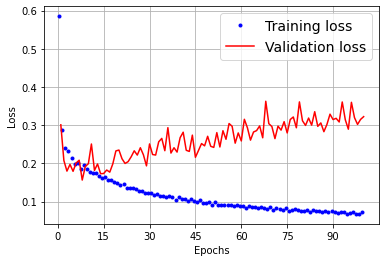

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [1023]:
np.random.seed(42)
tf.random.set_seed(42)

#GRU with regularization
'''
model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, len(all_data.columns)]),
    
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),

    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

#model10.compile(loss="mape", optimizer="adam")
model10.compile(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False, name="SGD"),loss='mean_squared_error')
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=epochs_,batch_size=batch_size_,
                    validation_data=(X_valid, Y_valid[:, 3::2]))#, callbacks = [es])
'''

'\nmodel10 = keras.models.Sequential([\n    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",\n                        input_shape=[None, len(all_data.columns)]),\n    \n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n    keras.layers.GRU(50, return_sequences=True,activation=\'tanh\'),\n    keras.layers.Dropout(0.2),\n\n    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))\n])\n\n#model10.compile(loss="mape", optimizer="adam")\nmodel10.compile(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False, name="SGD"),loss=\'mean_squared_error\')\nhistory2 = model10.fit(X_train, Y_train[:, 3::2], epochs=epochs_,batch_size=batch_size_,\n                    validation_data=(X_valid, Y_valid[:, 3::2]))#, callbacks = [es])\n'

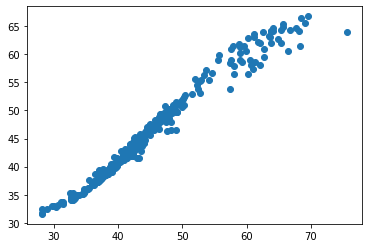

In [17]:
actual = return_actual(model6)

plt.scatter(actual["actual"],actual["predictions"])

In [18]:
from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(actual["actual"], actual["predictions"], squared=True)
rmse2 = mean_squared_error(actual["actual"].shift(-1).dropna(), actual["predictions"][0:len(actual["actual"].shift(-1).dropna())], squared=True)
rmse1-rmse2

-10.379239396728929

0     -0.575004
1     -0.689574
2     -0.589204
3     -0.410082
4     -0.360000
         ...   
244   -0.330000
245   -0.286614
246   -0.288200
247   -0.404334
248   -0.390000
Length: 249, dtype: float64

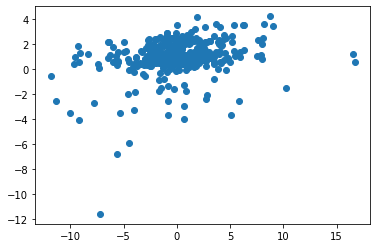

In [19]:
plt.scatter(actual["actual"].shift(1)-actual["actual"],actual["predictions"]-actual["actual"])


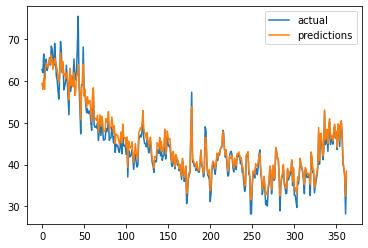

In [20]:
from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()